In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torchvision.models import ResNet50_Weights, resnet50
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split

from PIL import Image
import glob
import os
import random

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# # Load the CNN model (ResNet-50)
# resnet_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
# num_features = resnet_model.fc.in_features
# resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 1)  # Modify the final layer for regression (1 output)
# # resnet_model.fc = nn.Identity()

# resnet_model = nn.DataParallel(resnet_model)  

# # Load your pre-trained ResNet-50 model
# resnet_model.load_state_dict(torch.load('/home/janz/PROJECT/trained_models/cnn_model.pth'))
# resnet_model.to(device)
# resnet_model.eval()  # Set model to evaluation mode

# Define the ResNet model with separate layer processing
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)  # Load pretrained ResNet-50
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)  # Modify final layer for regression (1 output)
        self.feature_extractor = nn.Linear(self.resnet.fc.in_features, 15)  # Feature extraction layer

    def forward(self, x):
        # Pass input through ResNet layers individually
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        # Apply global average pooling (or other pooling method)
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten to 2D (batch_size, 2048)

        # Feature extraction layer
        features = self.feature_extractor(x)

        # Final output
        output = self.resnet.fc(x)

        return features, output

# Load the pre-trained ResNet-50 model
resnet_model = ResNetModel().to(device)

# Load your pre-trained ResNet-50 model weights
resnet_model.load_state_dict(torch.load('/home/janz/PROJECT/trained_models/cnn_model.pth'))
resnet_model.eval()  # Set model to evaluation mode

# Wrap the model with DataParallel if using multiple GPUs
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    resnet_model = nn.DataParallel(resnet_model)


Let's use 3 GPUs!


In [3]:
# Define the MLP model (should match the previously defined MLP architecture)
# class MLPModel(nn.Module):
#     def __init__(self):
#         super(MLPModel, self).__init__()
#         self.fc1 = nn.Linear(25, 100)
#         self.dropout1 = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(100, 100)
#         self.dropout2 = nn.Dropout(0.2)
#         self.fc3 = nn.Linear(100, 30)
#         self.fc4 = nn.Linear(30, 1)
#         self.feature_extractor = nn.Linear(30, 30)  # Feature extraction layer

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)
#         x = F.relu(self.fc3(x))
#         features = self.feature_extractor(x)  # Extract intermediate features
#         output = self.fc4(x)
#         return features, output

# # Define the MLP model (should match the previously defined MLP architecture)
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(25, 64)  # Increased neurons
        self.dropout1 = nn.Dropout(0.185)
        self.fc2 = nn.Linear(64, 128)  # Increased neurons
        self.dropout2 = nn.Dropout(0.185)
        self.fc3 = nn.Linear(128, 256)  # Increased neurons
        self.dropout3 = nn.Dropout(0.185)
        self.fc4 = nn.Linear(256, 128)  # Increased neurons
        self.dropout4 = nn.Dropout(0.185)
        self.fc5 = nn.Linear(128, 64)  # Increased neurons
        self.fc6 = nn.Linear(64, 1)
        self.feature_extractor = nn.Linear(64, 64)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)
        x = F.relu(self.fc5(x))
        features = self.feature_extractor(x)
        output = self.fc6(x)
        return features, output

# Load the MLP model
mlp_model = MLPModel().to(device)
mlp_model.load_state_dict(torch.load("/home/janz/PROJECT/trained_models/mlp_model.pth"))
mlp_model.eval()

MLPModel(
  (fc1): Linear(in_features=25, out_features=64, bias=True)
  (dropout1): Dropout(p=0.185, inplace=False)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (dropout2): Dropout(p=0.185, inplace=False)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (dropout3): Dropout(p=0.185, inplace=False)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (dropout4): Dropout(p=0.185, inplace=False)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=1, bias=True)
  (feature_extractor): Linear(in_features=64, out_features=64, bias=True)
)

In [17]:
# Step 3: Combine Models into a Single Integrated Model
class CombinedModel(nn.Module):
    def __init__(self, cnn_model, mlp_model):
        super(CombinedModel, self).__init__()
        self.cnn_model = cnn_model
        self.mlp_model = mlp_model

        # # Freeze the parameters of cnn_model
        # for param in self.cnn_model.parameters():
        #     param.requires_grad = False
        
        # # Freeze the parameters of mlp_model
        # for param in self.mlp_model.parameters():
        #     param.requires_grad = False

        cnn_features_size = 15  
        mlp_features_size = 64 
        
        # Calculate the combined input size for the FC layers
        combined_features_size = cnn_features_size + mlp_features_size
        
        # Define FC layers
        self.fc1 = nn.Linear(combined_features_size, 128)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x_cnn, x_mlp):
        # Forward pass through CNN model
        cnn_features, _ = self.cnn_model(x_cnn)
        
        # Forward pass through MLP model
        mlp_features, _ = self.mlp_model(x_mlp)

        # Concatenate features from both models
        combined_features = torch.cat((cnn_features, mlp_features), dim=1)

        # Apply FC layers with ReLU activation
        x = F.relu(self.fc1(combined_features))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        
        # Final output layer (no activation for regression)
        x = self.fc4(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the combined model
model = CombinedModel(resnet_model.module, mlp_model).to(device)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

# # Print the combined model architecture
# print(model)

Let's use 3 GPUs!


In [18]:
from eye_dataset import EyeDataset  # Import EyeDataset from your module

# Set seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

# Define directories for image loading
right_eye_dir = "/home/janz/PROJECT/Eye_Scans_Data/op2_png"
left_eye_dir = "/home/janz/PROJECT/Eye_Scans_Data/op5_png"

# Load and preprocess tabular data
csv_file = "/home/janz/PROJECT/Tabular_Datas/Tabular_for_cnn_updated.csv"
df = pd.read_csv(csv_file)

# Scale the target variable
df['Last_UCVA'] = df['Last_UCVA'] * 10

# Drop unnecessary columns
df.drop(columns=['Last_Efficacy Index', 'Surgery Date', 'Op.Time', 'Last_Target Sph',
                 'Therapeutic Cont L', 'Era', 'Season', 'Temp', 'Humidity'], inplace=True)

# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != "Ocular Treatment ID":
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])

# Split data into train, validation, and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Create datasets and dataloaders
transform = transforms.Compose([
    # Add any necessary transformations here (e.g., resizing, normalization, augmentation)
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = EyeDataset(train_data, transform=transform)
val_dataset = EyeDataset(val_data, transform=transform)
test_dataset = EyeDataset(test_data, transform=transform)

In [19]:
# Hyperparameters
num_epochs = 45
batch_size = 32
learning_rate = 0.0001

In [20]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=32, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=32, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=32, pin_memory=True)

In [21]:
import torch
torch.cuda.empty_cache()

In [22]:
from tqdm import tqdm  # Import tqdm for progress bar
import torch.cuda as cuda

# Initialize variables for early stopping
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 4

# Define criterion (loss function) and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    # Use tqdm to wrap train_loader for a progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as t:
        for cnn_input_tensor, mlp_input_tensor, targets in t:
            # Move tensors to the configured device
            cnn_input_tensor = cnn_input_tensor.to(device)
            mlp_input_tensor = mlp_input_tensor.to(device)
            targets = targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(cnn_input_tensor, mlp_input_tensor)
            
            # Calculate loss
            loss = criterion(outputs.squeeze(), targets)  # Assuming targets are 1D, squeeze to match output shape

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update progress bar description with current loss
            t.set_postfix(loss=loss.item())

            # Accumulate running loss
            running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation", unit="batch") as t:
            for cnn_input_tensor, mlp_input_tensor, targets in t:
                cnn_input_tensor = cnn_input_tensor.to(device)
                mlp_input_tensor = mlp_input_tensor.to(device)
                targets = targets.to(device)

                outputs = model(cnn_input_tensor, mlp_input_tensor)
                loss = criterion(outputs.squeeze(), targets)

                val_loss += loss.item()
                
                # Update progress bar description with current loss
                t.set_postfix(loss=loss.item())

    val_loss /= len(val_loader)
    print(f"Validation Loss after epoch {epoch+1}: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

print("Finished Training")

Epoch 1/45: 100%|██████████| 1071/1071 [03:54<00:00,  4.57batch/s, loss=8.65]


Epoch [1/45], Loss: 10.2150


Validation: 100%|██████████| 268/268 [00:49<00:00,  5.41batch/s, loss=2.99]


Validation Loss after epoch 1: 3.3622


Epoch 2/45: 100%|██████████| 1071/1071 [03:54<00:00,  4.57batch/s, loss=2.26]


Epoch [2/45], Loss: 5.3037


Validation: 100%|██████████| 268/268 [00:49<00:00,  5.40batch/s, loss=2.8]  


Validation Loss after epoch 2: 2.8454


Epoch 3/45: 100%|██████████| 1071/1071 [03:55<00:00,  4.55batch/s, loss=0.156]


Epoch [3/45], Loss: 5.0778


Validation: 100%|██████████| 268/268 [00:49<00:00,  5.39batch/s, loss=2.92]


Validation Loss after epoch 3: 2.9946


Epoch 4/45: 100%|██████████| 1071/1071 [03:54<00:00,  4.57batch/s, loss=4.96]


Epoch [4/45], Loss: 4.9511


Validation: 100%|██████████| 268/268 [00:49<00:00,  5.42batch/s, loss=2.87]


Validation Loss after epoch 4: 2.9439


Epoch 5/45: 100%|██████████| 1071/1071 [03:53<00:00,  4.59batch/s, loss=6.41]


Epoch [5/45], Loss: 4.8744


Validation: 100%|██████████| 268/268 [00:49<00:00,  5.40batch/s, loss=3.05]


Validation Loss after epoch 5: 3.5206


Epoch 6/45: 100%|██████████| 1071/1071 [03:54<00:00,  4.57batch/s, loss=1.93]


Epoch [6/45], Loss: 4.8426


Validation: 100%|██████████| 268/268 [00:49<00:00,  5.43batch/s, loss=2.77] 


Validation Loss after epoch 6: 2.7111


Epoch 7/45: 100%|██████████| 1071/1071 [03:54<00:00,  4.58batch/s, loss=11.7]


Epoch [7/45], Loss: 4.7934


Validation: 100%|██████████| 268/268 [00:49<00:00,  5.41batch/s, loss=3.06] 


Validation Loss after epoch 7: 2.6220


Epoch 8/45: 100%|██████████| 1071/1071 [03:54<00:00,  4.58batch/s, loss=2.48]


Epoch [8/45], Loss: 4.7617


Validation: 100%|██████████| 268/268 [00:49<00:00,  5.42batch/s, loss=2.77] 


Validation Loss after epoch 8: 2.7815


Epoch 9/45: 100%|██████████| 1071/1071 [03:54<00:00,  4.57batch/s, loss=1.41]


Epoch [9/45], Loss: 4.7000


Validation: 100%|██████████| 268/268 [00:49<00:00,  5.41batch/s, loss=2.87] 


Validation Loss after epoch 9: 2.6322


Epoch 10/45: 100%|██████████| 1071/1071 [03:54<00:00,  4.57batch/s, loss=7.09]


Epoch [10/45], Loss: 4.6539


Validation: 100%|██████████| 268/268 [00:49<00:00,  5.42batch/s, loss=2.72]


Validation Loss after epoch 10: 2.8879


Epoch 11/45: 100%|██████████| 1071/1071 [03:54<00:00,  4.57batch/s, loss=2.05]


Epoch [11/45], Loss: 4.6792


Validation: 100%|██████████| 268/268 [00:49<00:00,  5.41batch/s, loss=3.08]

Validation Loss after epoch 11: 3.4361
Early stopping at epoch 11
Finished Training


In [23]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

# Evaluation function for the combined model
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad(), tqdm(total=len(test_loader), desc='Testing') as pbar:
        for cnn_input_tensor, mlp_input_tensor, targets in test_loader:
            cnn_input_tensor = cnn_input_tensor.to(device)
            mlp_input_tensor = mlp_input_tensor.to(device)
            targets = targets.to(device)
            
            outputs = model(cnn_input_tensor, mlp_input_tensor).squeeze(1)

            all_predictions.extend(outputs.cpu().numpy().flatten())
            all_targets.extend(targets.cpu().numpy().flatten())
            pbar.update(1)  # Update the progress bar

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    return all_predictions, all_targets

# Evaluate the combined model
all_predictions, all_targets = evaluate_model(model, test_loader)

Testing: 100%|██████████| 335/335 [01:00<00:00,  5.50it/s]


In [32]:
binary_classification_threshold = 8
abs_difference_threshold = 1

# Check if the absolute difference is smaller than the threshold
abs_difference = np.abs(all_predictions - all_targets)
abs_difference_mask = abs_difference <= abs_difference_threshold

# Convert to binary classification based on threshold
binary_predictions = np.where(all_predictions >= binary_classification_threshold, 1, 0)
binary_targets = np.where(all_targets >= binary_classification_threshold, 1, 0)

for i in range(len(binary_predictions)):
    if abs_difference_mask[i]:
        binary_predictions[i] = binary_targets[i]

# Calculate precision, recall, accuracy, and AUC
precision = precision_score(binary_targets, binary_predictions)
recall = recall_score(binary_targets, binary_predictions)
accuracy = accuracy_score(binary_targets, binary_predictions)
auc = roc_auc_score(binary_targets, binary_predictions)

print(f'Test Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, AUC: {auc:.4f}')

# Calculate false alarm rate (FPR)
true_negatives = np.sum((binary_targets == 0) & (binary_predictions == 0))
false_positives = np.sum((binary_targets == 0) & (binary_predictions == 1))
false_alarm_rate = false_positives / (false_positives + true_negatives)

print(f'False Alarm Rate: {false_alarm_rate:.4f}')

Test Precision: 0.9184, Recall: 0.7944, Accuracy: 0.7654, AUC: 0.6982
False Alarm Rate: 0.3980


Confusion Matrix:
[[1679  335]
 [5067 3622]]


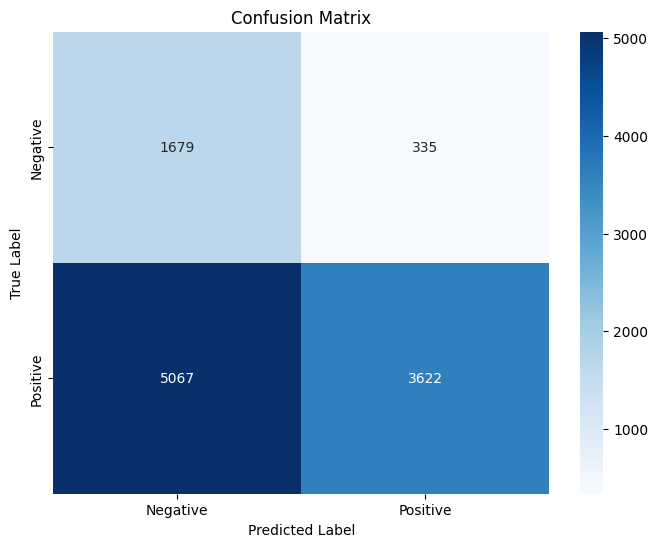

In [26]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

cm = confusion_matrix(binary_targets, binary_predictions)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

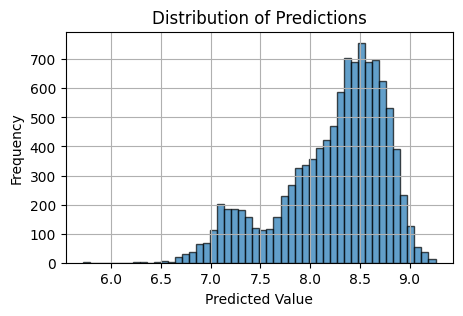

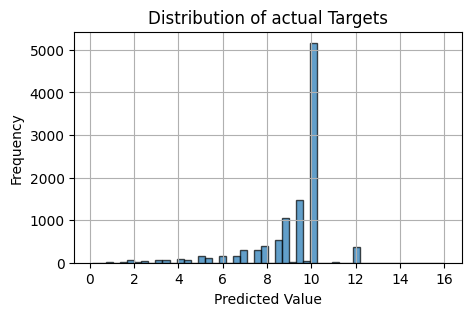

In [27]:
# Plotting the histogram
plt.figure(figsize=(5, 3))
plt.hist(all_predictions, bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting the histogram
plt.figure(figsize=(5, 3))
plt.hist(all_targets, bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of actual Targets')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()